<a href="https://colab.research.google.com/github/rafaeldsouza/mestrado/blob/main/Redes%20Neurais/forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para esta atividade deve ser feita uma base para o problema XOR, que deve ter somente 4 exemplos e não vai ter separação de treino e teste.

A arquitetura apresentada no fórum que trata sobre a fase forward do backpropagation https://ava.cefor.ifes.edu.br/mod/forum/view.php?id=1702157 deve ser implementada, em uma classe que herde BaseEstimator, ClassifierMixin. Os pesos podem ser devidos "manualmente" dentro do método fit. Só a fase forward será implementada. Portanto, só o método predict (ou predict_proba) deve ser implementado usando os cálculos que discutimos no fórum.


Apresente um gráfico mostrando a separação das classes usando um meshgrid, como feito nas tarefas anteriores.


A forma de entrega é como a das demais tarefas, um link para um jupyter notebook no github.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize
from scipy.special import expit
from sklearn.model_selection import train_test_split

In [18]:

def criaDataset(n=1000):
  x,y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
  y = np.array(y%2, dtype=int)
  return x,y
  
X,y = criaDataset()


In [19]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

In [6]:
def plotDataSet(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k],"o",alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

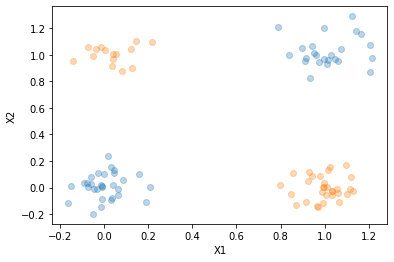

In [20]:
plotDataSet(Xtr, ytr)

In [10]:
def define_axes(x):
  min1, max1 = x[:,0].min(), x[:,0].max()
  min2, max2 = x[:,1].min(), x[:,1].max()
  return [min1-.1, max1+.1,min2-.1,max2+.1]

def plotPredictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0,x1 = np.meshgrid(x0s, x1s) 
    X_ = np.c_[x0.ravel(), x1.ravel()]
    ypred  = clf.predict(X_).reshape(x0.shape)
    plt.contourf(x0,x1,ypred,cmap=plt.cm.brg, alpha=0.2)

In [21]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [22]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass


class PseudoInversa(TrainingAlgorithm):
    def __init__(self, regularization=0):
        self.regularization = regularization
    def getW(self, X, y):
        if self.regularization == 0:
            return np.linalg.pinv(X) @ y
        return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y

In [23]:
from scipy.special import expit

def tanh(a):
    return expit(a)*2-1

In [31]:
class ELM(BaseEstimator, ClassifierMixin):
  @staticmethod
  def includebias(X):
      bias = np.ones((X.shape[0],1))
      Xb = np.concatenate((bias,X), axis=1)
      return Xb

  def __init__(self, n_hidden=10, regularization=0):
    self.n_hidden = n_hidden
    #self.regularization = regularization
    self.activation = tanh
    self.training_algorithm = PseudoInversa(regularization)
    self.wih = None
    self.who = None
    
  def fit(self, X, y):
    Xb = ELM.includebias(X)
    self.wih = np.random.uniform(-1, 1, size = (Xb.shape[1],self.n_hidden))
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includebias(H)
    yhot = self.encode_labels(y)
    self.who = self.training_algorithm.getW(Hb, yhot)

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def predict(self, X, y=None):
      Xb = ELM.includebias(X)
      H = self.activation(Xb @ self.wih)
      Hb=ELM.includebias(H)
      a = Hb @ self.who
      return a

1.0
1.0


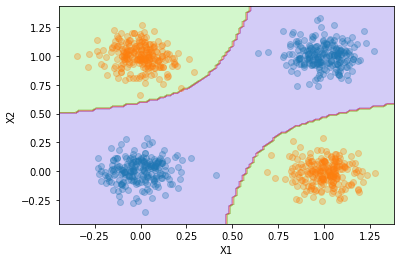

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class ELM(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=10, regularization=0):
        self.ihw = None
        self.how = None
        self.activation = tanh
        self.n_hidden = n_hidden
        self.training_algorithm = PseudoInversa(regularization)
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        Xb = ELM.includebias(X)
        self.ihw = np.random.uniform(-1, 1, size=(Xb.shape[1],self.n_hidden))
        H = self.__input2hidden_activation(Xb)
        Hb = ELM.includebias(H)
        yhot = self.encode_labels(y)
        self.how = self.training_algorithm.getW(Hb, yhot)
    
    def __input2hidden_activation(self, X):
        return self.activation(X @ self.ihw)

    def predict(self, X):
        Xb = ELM.includebias(X)
        H = self.__input2hidden_activation(Xb)
        Hb = ELM.includebias(H)
        a = Hb @ self.how
        if self.how.shape[1] == 1:
            idx = np.array(a > 0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

elm = ELM(30, 0.01)
elm.fit(Xtr, ytr)
print(accuracy(ytr, elm.predict(Xtr)))
print(accuracy(yte, elm.predict(Xte)))
plotDataSet(Xte, yte)
plotPredictions(elm, Xte)